In [109]:
#Post-Perturbation Model
# Import NumPy for array handling
#
import numpy as np
#
# A simple grid refinement function
#
def grid_refine_inner_edge(x_orig,nlev,nspan):
    x     = x_orig.copy()
    rev   = x[0]>x[1]
    for ilev in range(nlev):
        x_new = 0.5 * ( x[1:nspan+1] + x[:nspan] )
        x_ref = np.hstack((x,x_new))
        x_ref.sort()
        x     = x_ref
        if rev:
            x = x[::-1]
    return x
#
# Some natural constants
#
au  = 1.49598e13     # Astronomical Unit       [cm]
pc  = 3.08572e18     # Parsec                  [cm]
ms  = 1.98892e33     # Solar mass              [g]
ts  = 5.78e3         # Solar temperature       [K]
ls  = 3.8525e33      # Solar luminosity        [erg/s]
rs  = 6.96e10        # Solar radius            [cm]
ss  = 5.6703e-5      # Stefan-Boltzmann const  [erg/cm^2/K^4/s]
kk  = 1.3807e-16     # Bolzmann's constant     [erg/K]
mp  = 1.6726e-24     # Mass of proton          [g]
GG  = 6.67408e-08    # Gravitational constant  [cm^3/g/s^2]
pi  = np.pi          # Pi

#
# Star parameters
#
mstar    = ms
rstar    = rs
tstar    = ts
pstar    = np.array([0.,0.,0.])

#
# Disk parameters
#
sigmag0  = 1e1               # Sigma gas at 1 AU
sigmad0  = sigmag0 * 0.01    # Sigma dust at 1 AU
plsig    = -1.0e0            # Powerlaw of the surface density

#
# First make a simple analytical disk model roughly along the
# lines of Chiang & Goldreich (1997), but with just a single
# vertical layer and with a constant radiative incidence angle.
#
flang    = 0.05      # The assumed constant radiative incidence angle
nr       = 100        # Nr of radial grid points
rin      = 10*au     # Inner radius
rout     = 100*au    # Outer radius
nlev_rin = 12        # Grid refinement at the inner edge: nr of cycles
nspan_rin= 3         # Grid refinement at the inner edge: nr of cells each cycle
ri       = np.logspace(np.log10(rin),np.log10(rout),nr+1)
ri       = grid_refine_inner_edge(ri,nlev_rin,nspan_rin)   # Refinement at inner edge
rc       = 0.5 * ( ri[:-1] + ri[1:] )
nr       = len(rc)   # Recompute nr, because of refinement at inner edge
r        = rc        # The radial grid of the analytic disk model
lstar    = 4*pi*rstar**2*ss*tstar**4   # Stellar luminosity
firr     = flang*lstar/(4*pi*r**2)     # Irradiative flux
tmid     = (firr/ss)**0.25             # Estimate of midplane temperature
cs       = np.sqrt(kk*tmid/(2.3*mp))   # Isothermal sound speed at midplane
omk      = np.sqrt(GG*mstar/r**3)      # The Kepler angular frequency
hp       = cs/omk                      # The pressure scale height
hpr      = hp/r                        # The dimensionless hp
sigmad   = (sigmad0 * (r/au)**plsig)   # The surface density profile

#Redefine sigmad for the implemented perturbation

def pert(radius, amplitude, location, width):
    value = amplitude*np.exp(-((radius-location)/width)**2)
    return value

a = .25
l = 25*au
w = au
sigmad *= (1 + pert(r, a, l, w))

#
# Vertical grid parameters (theta-grid in spherical coordinates)
#
ntheta   = 100
zrmax    = 0.5
thetaup  = np.pi*0.5 - 0.5e0

#
# Make the theta and phi coordinates
#
nphi     = 1
thetai   = np.linspace(thetaup,0.5e0*np.pi,ntheta+1)
phii     = np.linspace(0.e0,np.pi*2.e0,nphi+1)
thetac   = 0.5 * ( thetai[0:ntheta] + thetai[1:ntheta+1] )
phic     = 0.5 * ( phii[0:nphi] + phii[1:nphi+1] )

#
# Make the 2-D grid (actually 3-D but with axisymmetry)
#
qq       = np.meshgrid(rc,thetac,phic,indexing='ij')
rr       = qq[0]
tt       = qq[1]
zr       = np.pi/2.e0 - qq[1]

#
# Expand the 1-D analytic model to 2-D
#
sigmad_3d  = np.meshgrid(sigmad,thetac,phic,indexing='ij')[0]
hh         = np.meshgrid(hp,thetac,phic,indexing='ij')[0]
hhr        = np.meshgrid(hpr,thetac,phic,indexing='ij')[0]

#
# Make the dust density model
#
rhod     = sigmad_3d / (np.sqrt(2.e0*np.pi)*hh) * np.exp(-((zr**2/hhr**2)/2.e0))
# Monte Carlo parameters
#
nphot    = 1000000

#
# Write the wavelength_micron.inp file
#
lam1     = 0.1e0
lam2     = 7.0e0
lam3     = 25.e0
lam4     = 1.0e4
n12      = 20
n23      = 100
n34      = 30
lam12    = np.logspace(np.log10(lam1),np.log10(lam2),n12,endpoint=False)
lam23    = np.logspace(np.log10(lam2),np.log10(lam3),n23,endpoint=False)
lam34    = np.logspace(np.log10(lam3),np.log10(lam4),n34,endpoint=True)
lam      = np.concatenate([lam12,lam23,lam34])
nlam     = lam.size
#
# Write the wavelength file
#
with open('wavelength_micron.inp','w+') as f:
    f.write('%d\n'%(nlam))
    for value in lam:
        f.write('%13.6e\n'%(value))
#
#
# Write the stars.inp file
#
with open('stars.inp','w+') as f:
    f.write('2\n')
    f.write('1 %d\n\n'%(nlam))
    f.write('%13.6e %13.6e %13.6e %13.6e %13.6e\n\n'%(rstar,mstar,pstar[0],pstar[1],pstar[2]))
    for value in lam:
        f.write('%13.6e\n'%(value))
    f.write('\n%13.6e\n'%(-tstar))
#
# Write the grid file
#
with open('amr_grid.inp','w+') as f:
    f.write('1\n')                       # iformat
    f.write('0\n')                       # AMR grid style  (0=regular grid, no AMR)
    f.write('100\n')                     # Coordinate system: spherical
    f.write('0\n')                       # gridinfo
    f.write('1 1 0\n')                   # Include r,theta coordinates
    f.write('%d %d %d\n'%(nr,ntheta,1))  # Size of grid
    for value in ri:
        f.write('%13.6e\n'%(value))      # X coordinates (cell walls)
    for value in thetai:
        f.write('%13.6e\n'%(value))      # Y coordinates (cell walls)
    for value in phii:
        f.write('%13.6e\n'%(value))      # Z coordinates (cell walls)
#
# Write the density file
#
with open('dust_density.inp','w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n'%(nr*ntheta*nphi))     # Nr of cells
    f.write('1\n')                       # Nr of dust species
    data = rhod.ravel(order='F')         # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%13.6e")
    f.write('\n')
#
# Dust opacity control file
#
with open('dustopac.inp','w+') as f:
    f.write('2               Format number of this file\n')
    f.write('1               Nr of dust species\n')
    f.write('============================================================================\n')
    f.write('1               Way in which this dust species is read\n')
    f.write('0               0=Thermal grain\n')
    f.write('silicate        Extension of name of dustkappa_***.inp file\n')
    f.write('----------------------------------------------------------------------------\n')
#
# Write the radmc3d.inp control file
#
with open('radmc3d.inp','w+') as f:
    f.write('nphot = %d\n'%(nphot))
    f.write('scattering_mode_max = 1\n')
    f.write('iranfreqmode = 1\n')

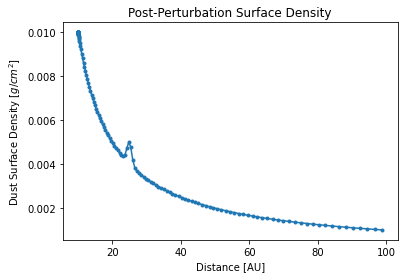

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_temperature.dat
Reading dust_temperature.dat


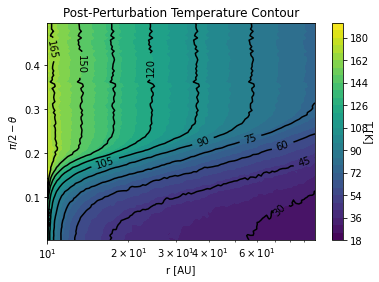

Stored 'xGridPost' (ndarray)
Stored 'yGridPost' (ndarray)
Stored 'PostPertTemp' (ndarray)


In [117]:
#Post-Perturbation Model
import matplotlib.pyplot as plt
from radmc3dPy import *

#Create Surface Density Plot
plt.plot(r/au, sigmad, '.-')
plt.title('Post-Perturbation Surface Density')
plt.xlabel('Distance [AU]')
plt.ylabel('Dust Surface Density [$g/cm^2$]')
plt.show()

#Read the Temperature Data
data = analyze.readData(dtemp=True)
data.readDustTemp()

#Create the temperature plot at the radius of the perturbation


#Create the temperature contour
c = plt.contourf(data.grid.x/natconst.au, np.pi/2.-data.grid.y, data.dusttemp[:,:,0,0].T, 30)
plt.xlabel('r [AU]')
plt.ylabel(r'$\pi/2-\theta$')
plt.title('Post-Perturbation Temperature Contour')
plt.xscale('log')
cb = plt.colorbar(c)
cb.set_label('T [K]', rotation=270.)

c = plt.contour(data.grid.x/natconst.au, np.pi/2.-data.grid.y, data.dusttemp[:,:,0,0].T, 10,  colors='k', linestyles='solid')
plt.clabel(c, inline=1, fontsize=10)
plt.show()

xGridPost = data.grid.x/natconst.au
yGridPost = np.pi/2.-data.grid.y
PostPertTemp = data.dusttemp[:,:,0,0].T

%store xGridPost
%store yGridPost
%store PostPertTemp

Executing RADMC-3D Command:
radmc3d image npix 200 incl 60.0 sizeau 200 lambda 1000.0 phi 30.0 pointau 0.0  0.0  0.0 fluxcons
  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2020 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, register to  
                     the RADMC-3D forum:                         
            h

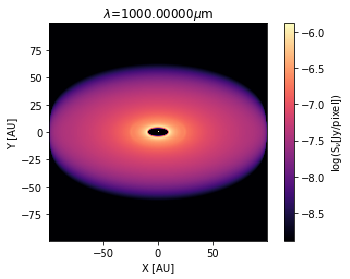

Executing RADMC-3D Command:
radmc3d image npix 200 incl 60.0 sizeau 200 lambda 10 phi 30.0 pointau 0.0  0.0  0.0 fluxcons
  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2020 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, register to  
                     the RADMC-3D forum:                         
            http:

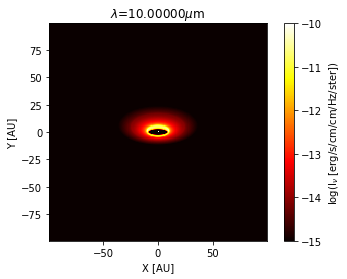

Text(-90, 80, 'With isotropic scattering')

In [111]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from radmc3dPy.image import *
from radmc3dPy.analyze import *
from radmc3dPy.natconst import *

#
# Make sure to have done the following beforhand:
#
#  First compile RADMC-3D
#  Then run:
#   python problem_setup.py
#   radmc3d mctherm
#

dpc = 140.     # Distance in parsec (for conversion to Jy/pixel in 1.3 mm map)

#
# Make and plot image of full disk at 1.3 mm: thermal dust emission
#
makeImage(npix=200,incl=60.,phi=30.,wav=1.0e3,sizeau=200)   # This calls radmc3d 
im_mm = readImage()
plt.figure()
plotImage(im_mm,au=True,log=True,maxlog=3,bunit='jy/pixel',dpc=dpc,cmap='magma')

#
# Make and plot image of full disk at 1 microns: scattered light
#
makeImage(npix=200,incl=60.,phi=30.,wav=10,sizeau=200)   # This calls radmc3d 
im_1 = readImage()
plt.figure()
plotImage(im_1,au=True,log=True,vmax=-10,vmin=-15,bunit='inu',cmap='hot')
plt.text(-90,80,'With isotropic scattering',color='white')